# OSMnx

Testing the [OSMnx](https://geoffboeing.com/2016/11/osmnx-python-street-networks/) library for loading and processing OSM data.

See these [notebooks](https://github.com/gboeing/osmnx-examples/tree/master/notebooks) for examples of using the library.

In [ ]:
# !brew install spatialindex

In [323]:
import networkx as nx
import itertools
import osmnx as ox
import glob
import itertools
from matplotlib import cm

%matplotlib inline
ox.config(log_console=True, use_cache=True, data_folder='')

In [324]:
graphml_fnames = glob.glob('data/boeing_dataverse/06-CA-cities-street_networks-graphml/*.graphml')

In [325]:
def remove_parallels(G):
    parallel_edges = [(u, v, key) for (u, v, key) in G.edges(keys=True) if key != 0]
    G.remove_edges_from(parallel_edges)

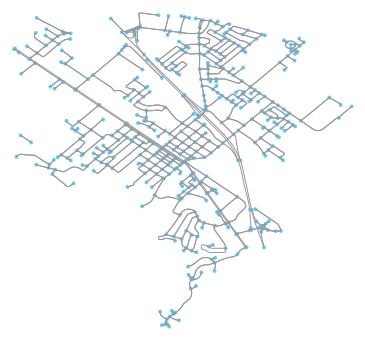

In [407]:
G = ox.load_graphml(graphml_fnames[1])
remove_parallels(G)
fig, ax = ox.plot_graph(G)

In [408]:
def simulate_step(G_sim, edge_capacities):
    betw_cent = nx.edge_betweenness_centrality(G_sim, weight='length')
    
    failed = [(u, v) for (u, v, key) in G_sim.edges(keys=True)
                 if betw_cent[(u,v)] > edge_capacities[(u,v)]]
    
    G_sim.remove_edges_from(failed)
    
    return failed


def simulation(G, failed, edge_capacities):
    # note modifies G
    step = -1
    
    nx.set_edge_attributes(G, -1, 'failure_step')
    G_sim = G.copy()
    G_sim.remove_edges_from(failed)
     
    while len(failed) > 0:
        print('stepping')
        step += 1
        nx.set_edge_attributes(G, {(u, v, 0): step for (u, v) in failed}, 'failure_step')
        failed = simulate_step(G_sim, edge_capacities)

        
    return step

In [409]:
betw_cent = nx.edge_betweenness_centrality(G, weight='length')
edge_capacities = {k: v * 1.001 for k, v in betw_cent.items()}

max_betw_cent_edge = max(betw_cent, key=betw_cent.get)
max_betw_cent = betw_cent[max_betw_cent_edge]

max_step = simulation(G, [max_betw_cent_edge], edge_capacities)

stepping
stepping
stepping
stepping
stepping


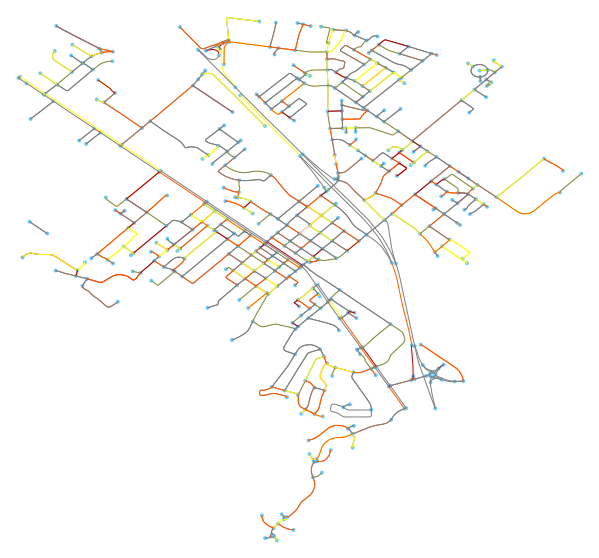

In [414]:
ec = ['grey' if failure_steps[e] == -1 else cm.hot(1 - failure_steps[e] / max_step) for e in edges]

fig, ax = ox.plot_graph(G, edge_color=ec, fig_height=10)

# plot of at which step the road fails (note this might be buggy)

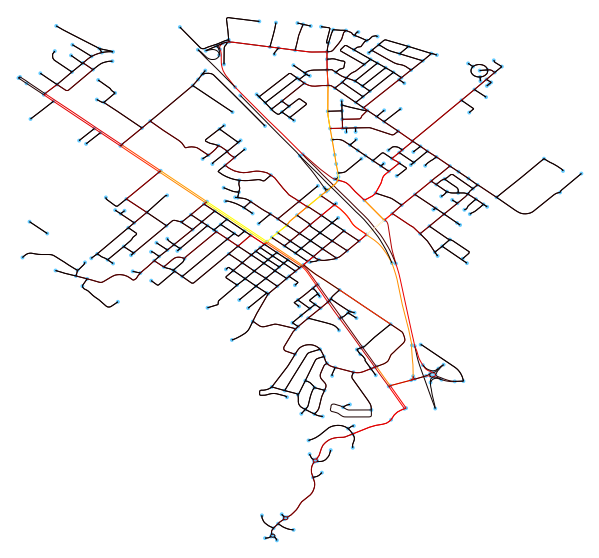

In [416]:
betw_cent = nx.edge_betweenness_centrality(G, weight='length')

# highlight all parallel edges in purple
ec = [cm.hot(betw_cent[(u,v)] / max_betw_cent) for u, v in G.edges()]

fig, ax = ox.plot_graph(G, edge_color=ec, fig_height=10)